In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging, print_dictionary
from result_script import *
from csrank.experiments.constants import DCFS, DCMS, SDA_DC
from csrank.constants import DISCRETE_CHOICE
import numpy as np

Using TensorFlow backend.
/home/prithagupta/anaconda3/envs/csrank/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/home/prithagupta/anaconda3/envs/csrank/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
FOLDER = "journalresults"
log_path = os.path.join(DIR_PATH, 'logs', 'results_dc.log')
latex_path = os.path.join(DIR_PATH, FOLDER, 'discrete_choice.tex')
df_path_combined = os.path.join(DIR_PATH, FOLDER , "DiscreteChoice.csv")

setup_logging(log_path=log_path, level=logging.ERROR)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', "sushi_dc", 'tag_genome_dc', "letor_dc", "exp_dc"]

markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P", "8", "s", 'H']
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
learning_problem = DISCRETE_CHOICE
learning_model = learners_map[learning_problem]
models_dict = dict(zip(DCFS, DCMS))

In [3]:
models_dict

{'feta_dc': 'FETA-Net',
 'fate_dc': 'FATE-Net',
 'fetalinear_dc': 'FETA-Linear',
 'fatelinear_dc': 'FATE-Linear',
 'sda_dc': 'SDA',
 'sda_dc_fixed': 'SDA-Fixed',
 'sda_dropout_dc': 'SDA-Dropout',
 'ranknet_dc': 'RankNet',
 'ranksvm_dc': 'PairwiseSVM',
 'multinomial_logit_model': 'LogitModel',
 'nested_logit_model': 'NestedLogit',
 'generalized_extreme_value': 'GenNestedLogit',
 'paired_combinatorial_logit': 'PairedLogit',
 'mixed_logit_model': 'MixedLogit',
 'random_dc': 'Random'}

In [4]:
import re
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]]
    return x
def create_final_result(dataset, dataset_function=get_combined_results ,latex_row=False):
    df_full = dataset_function(dataset, logger, learning_problem, latex_row=latex_row)
    data = []
    for dataset, df in df_full.groupby(['Dataset']):
        for m in DCFS:
            row = df[df[learning_model].str.contains(m)].values
            if SDA_DC == m:
                row = df[df[learning_model].str.contains(m) & ~df[learning_model].str.contains('fixed')].values
            onerow = None
            if len(row) > 1:
                if dataset_function==get_combined_results:
                    values = np.array([get_val(val[2]) for val in row])
                else:
                    values = np.array([[val[2], val[2] - val[7]] for val in row])
                maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0][0]
                logger.error("dataset {} model {}, vals {}, maxi {}".format(dataset, row[:, 1], values, maxi))
                row = row[maxi]
                row[1] = models_dict[m]
                onerow = row
            elif len(row)==1:
                row[0][1] = models_dict[m]
                onerow = row[0]
                logger.error("dataset {} model {}".format(dataset, onerow))
            if onerow is not None:
                onerow[0] = get_dataset_name(onerow[0])
                data.append(onerow)
    columns = df_full.columns
    dataframe = pd.DataFrame(data, columns=columns)
    dataframe = dataframe.sort_values(by=[columns[0], columns[2]], ascending=[True, False])
    return dataframe

In [5]:
d = datasets[0]
df = create_final_result(d)
df

,Dataset,DiscreteChoiceModel,Accuracy,Top-2,Top-3,Top-4,Top-5,Top-6
0,Hypervolume,FETA-Net,0.769±0.022,0.875±0.020,0.933±0.007,0.961±0.004,0.980±0.001,0.991±0.001
1,Hypervolume,FATE-Net,0.730±0.018,0.855±0.019,0.920±0.013,0.949±0.009,0.968±0.006,0.980±0.003
11,Hypervolume,GenNestedLogit,0.293±0.018,0.369±0.019,0.471±0.021,0.567±0.018,0.663±0.014,0.756±0.009
10,Hypervolume,NestedLogit,0.291±0.003,0.416±0.005,0.511±0.007,0.582±0.006,0.651±0.006,0.722±0.004
2,Hypervolume,FETA-Linear,0.236±0.042,0.314±0.044,0.404±0.042,0.484±0.034,0.560±0.028,0.634±0.025
4,Hypervolume,SDA,0.233±0.019,0.320±0.023,0.417±0.029,0.505±0.033,0.589±0.036,0.671±0.037
5,Hypervolume,SDA-Fixed,0.224±0.042,0.319±0.030,0.423±0.029,0.519±0.024,0.602±0.021,0.683±0.016
7,Hypervolume,RankNet,0.203±0.004,0.276±0.006,0.369±0.006,0.462±0.005,0.562±0.004,0.665±0.007
9,Hypervolume,LogitModel,0.201±0.008,0.267±0.010,0.360±0.010,0.456±0.008,0.559±0.004,0.664±0.004
13,Hypervolume,MixedLogit,0.189±0.014,0.338±0.017,0.451±0.019,0.542±0.020,0.621±0.013,0.692±0.010


In [6]:
import copy
from csrank.experiments.constants import PCL, RANDOM_DC, FETALINEAR_DC, FATELINEAR_DC, SDA_DC
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, get_combined_results_plot ,latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
searchFor = ['Nearest Neighbour', "5 Objects", "Critique", 'Largest', 'Median']
df = dataFrame[~dataFrame['Dataset'].str.contains('|'.join(searchFor))]
df.replace(to_replace=r' 10 Objects', value='', regex=True, inplace=True)
searchFor = [models_dict[PCL], models_dict[RANDOM_DC], 
             #models_dict[FETALINEAR_DC], models_dict[FATELINEAR_DC], 
             'Fixed']
df = df[~df[learning_model].str.contains('|'.join(searchFor))]
df.replace(to_replace=r'Tag Genome ', value='Tag Genome \n', regex=True, inplace=True)
df.replace(to_replace=r'LETOR-', value='LETOR\n', regex=True, inplace=True)
df.replace(to_replace=r'MNIST-', value='MNIST\n', regex=True, inplace=True)
df.head()

,Dataset,DiscreteChoiceModel,Accuracy,Top-2,Top-3,Top-4,Top-5,Top-6,AccuracySe,Top-2se,Top-3se,Top-4se,Top-5se,Top-6se
0,Hypervolume,FETA-Net,0.7689,0.8751,0.9330,0.9613,0.9795,0.9906,0.0217,0.0200,0.0073,0.0043,0.0011,0.0013
1,Hypervolume,FATE-Net,0.7298,0.8548,0.9198,0.9490,0.9680,0.9802,0.0178,0.0192,0.0131,0.0086,0.0059,0.0034
2,Hypervolume,GenNestedLogit,0.2931,0.3695,0.4715,0.5667,0.6630,0.7563,0.0178,0.0195,0.0206,0.0182,0.0139,0.0085
3,Hypervolume,NestedLogit,0.2912,0.4158,0.5110,0.5817,0.6507,0.7222,0.0033,0.0049,0.0066,0.0065,0.0056,0.0043
4,Hypervolume,FETA-Linear,0.2359,0.3143,0.4037,0.4837,0.5598,0.6345,0.0424,0.0445,0.0424,0.0344,0.0277,0.0246


In [7]:
df.Dataset.unique(), df[learning_model].unique()

(array(['Hypervolume', 'Medoid', 'MNIST\nMode', 'MNIST\nUnique', 'Sushi',
        'Tag Genome \nDissimilar Movie', 'Tag Genome \nSimilar Movie',
        'LETOR\nMQ2007list', 'LETOR\nMQ2008list', 'Expedia'], dtype=object),
 array(['FETA-Net', 'FATE-Net', 'GenNestedLogit', 'NestedLogit',
        'FETA-Linear', 'SDA', 'RankNet', 'LogitModel', 'MixedLogit',
        'PairwiseSVM', 'FATE-Linear', 'SDA-Dropout'], dtype=object))

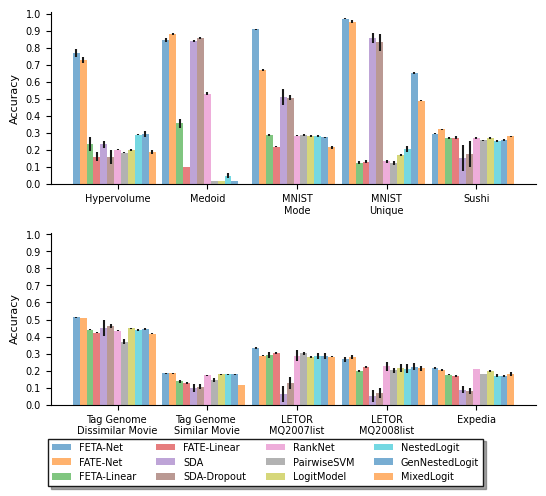

In [11]:
from csrank.constants import DISCRETE_CHOICE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
# create plot
extension = 'pdf'
fname = os.path.join(DIR_PATH, FOLDER, "{}_{}.{}")
start = 0.0
ncols = 4
params = dict(loc='lower right', bbox_to_anchor=(0.9, -0.5), ncol=ncols, fancybox=False, shadow=True,
                facecolor='white', edgecolor='k', fontsize=7)
bar_plot_for_problem2(df, learning_problem, start, params, extension)

In [16]:
import copy
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(df_path_combined)

In [9]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]*1e-3]
    return x
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[[learning_model,col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df[learning_model] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

import re
import string
def create_latex(df):
    grouped = df.groupby(['Dataset'])
    code = ""
    for name, group in grouped:
        custom_dict = dict()
        for i, m in enumerate(DCMS):
            custom_dict[m] = i
        group['rank'] = group[learning_model].map(custom_dict)
        group.sort_values(by='rank', inplace=True)
        del group["Dataset"]
        del group['rank']
        group = mark_best(group)
        group[learning_model].replace(to_replace=['PairwiseSVM'], value='pairwisesvm',inplace=True)
        group[learning_model].replace(to_replace=['RankNetDC'], value='ranknetdc',inplace=True)
        group[learning_model].replace(to_replace=['LogitModel'], value='mnl',inplace=True)
        group[learning_model].replace(to_replace=['NestedLogit'], value='nlm',inplace=True)
        group[learning_model].replace(to_replace=['GenNestedLogit'], value='gnl',inplace=True)
        group[learning_model].replace(to_replace=['MixedLogit'], value='mlm',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Net'], value='fatedc',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Net'], value='fetadc',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Linear'], value='fatelineardc',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Linear'], value='fetalineardc',inplace=True)
        group[learning_model].replace(to_replace=['Random'], value='random',inplace=True)
        print("########## Name {}#################".format(name))
        code = code + "\n\t\tName {} \t\t\n\n".format(name)
        if "5 Objects" in name:
            group = group.drop(columns='Top-5')
        group = group.drop(columns='Top-2')
        group = group.drop(columns='Top-4')
        latex_code = group.to_latex(index = False)
        latex_code = latex_code.replace(' ',"")
        latex_code = latex_code.replace('&'," & ")
        latex_code = str(latex_code)
        for learner in group[learning_model]:
            latex_code = latex_code.replace(learner, "\\{}".format(learner))
        latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
        #latex_code = latex_code.replace("0.", ".")
        code = code + latex_code
    return code
code = ""
for dataset in datasets:
    df = create_final_result(dataset, latex_row=True)
    df.sort_values(by='Dataset')
    df = df[~df[learning_model].str.contains("PairedLogit")]
    code = code + create_latex(df)
f= open(latex_path,"w+")
f.write(code)
f.close()

########## Name Hypervolume#################
########## Name Medoid#################
########## Name Nearest Neighbour#################
########## Name Largest#################
########## Name Median#################
########## Name Mode#################
########## Name Unique#################
########## Name Sushi#################
########## Name Best Critique-Fit Movie d=+1#################
########## Name Best Critique-Fit Movie d=-1#################
########## Name Impostor Critique-Fit Movie d=+1#################
########## Name Impostor Critique-Fit Movie d=-1#################
########## Name Tag Genome Dissimilar#################
########## Name Tag Genome Similar#################
########## Name LETOR MQ2007 10 Objects#################
########## Name LETOR MQ2007 5 Objects#################
########## Name LETOR MQ2008 10 Objects#################
########## Name LETOR MQ2008 5 Objects#################
########## Name Expedia 10 Objects#################
########## Name Expedia 5

# Run Till Here

for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

def get_results_for_dataset_2(del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {2} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset = ANY({3}) AND {1}.dataset_params->>\'dataset_type\'= ANY({4})"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'].get("learner", {}).get("n_hidden", [])
        if job['hp_ranges'].get("learner", {}).get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    cols = list(df_full.columns)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET_" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df